### Exploring EEG Signal Prediction

In [1]:
%load_ext autoreload

In [14]:
from dynaconf import settings
from data import EEGDataset, stackplot, normalize, butter_lowpass_filter2, convert_to_tfr
import torch
import eegvis
import torch.nn as nn
import random
from models import LSTM, Average, preds_with_sliding_window, check_model_is_cuda

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [16]:
select_channels, length, n_predictions = settings.SELECT_CHANNELS, settings.LENGTH, settings.N_PREDICTIONS

In [17]:
batch_size = 64

In [18]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV

train_dataset = EEGDataset(train_dataset_csv, length, select_channels, max_num_examples=-1, transform=normalize, filter_freq=False)
dev_dataset = EEGDataset(dev_dataset_csv, length, select_channels, max_num_examples=128, transform=normalize, filter_freq=False)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

Found 2765 recordings
By set limit only using 2764 recordings
Removing recordings of insufficient length...
Removed 193 of 2764 recordings. There are now 2571 recordings.
Found 345 recordings
By set limit only using 128 recordings
Removing recordings of insufficient length...
Removed 7 of 128 recordings. There are now 121 recordings.


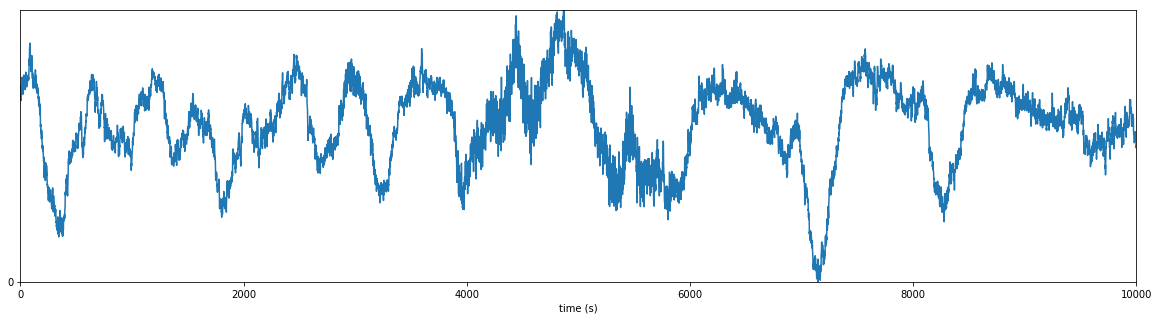

In [19]:
stackplot(train_dataset[2])

In [10]:
def train(num_epochs):
    model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
                
            data = data.cuda()
            y = data[:, :, -n_predictions:]
            data = data[:, :, :-n_predictions] # clip of the end which is being predicted 
            data = torch.transpose(data, 1, 2)
            a = model(data)
            loss = criteron(a.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 10 == 0:
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {sum(running_losses)/len(running_losses)}")
                running_losses.clear()

In [11]:
def train_on_tfr(model, num_epochs):
    model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
                
            data = convert_to_tfr(data.view(-1, data.shape[-1]), window_size=20).float()
            data = data.cuda()
            y = data[:, -n_predictions:, :]
            data = data[:, :-n_predictions, :]
            
            a = model(data)
            loss = criteron(a, y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 10 == 0:
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {sum(running_losses)/len(running_losses)}")
                running_losses.clear()

#### train a model 

In [13]:
# raw signal
num_epochs = 10
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)
model = model.cuda()
train(20)

epoch 0 | iter 0 | Running Loss 0.19485720992088318
epoch 0 | iter 10 | Running Loss 0.18407977968454362
epoch 0 | iter 20 | Running Loss 0.149504953622818
epoch 0 | iter 30 | Running Loss 0.13239462822675704
epoch 0 | iter 40 | Running Loss 0.09341693446040153
epoch 1 | iter 41 | Running Loss 0.08379314094781876
epoch 1 | iter 51 | Running Loss 0.07104407660663128
epoch 1 | iter 61 | Running Loss 0.05515981875360012
epoch 1 | iter 71 | Running Loss 0.044971422851085664
epoch 1 | iter 81 | Running Loss 0.03875071480870247
epoch 2 | iter 82 | Running Loss 0.03787645697593689
epoch 2 | iter 92 | Running Loss 0.0358587846159935
epoch 2 | iter 102 | Running Loss 0.035253565013408664
epoch 2 | iter 112 | Running Loss 0.03390808161348104
epoch 2 | iter 122 | Running Loss 0.03650403115898371
epoch 3 | iter 123 | Running Loss 0.021961737424135208
epoch 3 | iter 133 | Running Loss 0.031718211434781554
epoch 3 | iter 143 | Running Loss 0.02824933808296919
epoch 3 | iter 153 | Running Loss 0.0211

KeyboardInterrupt: 

In [17]:
# TFR signal 
num_epochs = 10
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(tfr_model.parameters(), lr=.0005)
tfr_model = tfr_model.cuda()
train_on_tfr(tfr_model, 20)

epoch 0 | iter 0 | Running Loss 0.016866352409124374
epoch 0 | iter 10 | Running Loss 0.01391576686874032
epoch 0 | iter 20 | Running Loss 0.007625294150784612
epoch 0 | iter 30 | Running Loss 0.004046067083254457
epoch 1 | iter 32 | Running Loss 0.003479846636764705
epoch 1 | iter 42 | Running Loss 0.0030779044143855573
epoch 1 | iter 52 | Running Loss 0.0030070046661421655
epoch 1 | iter 62 | Running Loss 0.0027203432749956847
epoch 2 | iter 64 | Running Loss 0.002398609940428287
epoch 2 | iter 74 | Running Loss 0.002767658932134509
epoch 2 | iter 84 | Running Loss 0.0024605185142718257
epoch 2 | iter 94 | Running Loss 0.0024849165929481387
epoch 3 | iter 96 | Running Loss 0.0027289041317999363
epoch 3 | iter 106 | Running Loss 0.002445262379478663
epoch 3 | iter 116 | Running Loss 0.0023478913586586713


KeyboardInterrupt: 

In [30]:
torch.save(model.state_dict(), "models/saved_models/lstm_gen_v1.1.pt")
# torch.save(tfr_model.state_dict(), "models/saved_models/tfr_lstm_gen_v0.1.pt")

#### Or load one

In [7]:
model.load_state_dict(torch.load("models/saved_models/lstm_gen_v1.0.2.pt"))
tfr_model.load_state_dict(torch.load("models/saved_models/tfr_lstm_gen_v0.1.pt"))

### Vizualize Preds

In [15]:
import math
def preds_with_sliding_window(x, num_inputs, model):
    if len(x.shape) == 2:
        # this is a single example rather than batch
        x = x.view(x.shape[0], 1, x.shape[1])


    output_length = settings.N_PREDICTIONS

    assert(len(x.shape) == 3), "Preds with sliding window takes shape (n, t, c)"
    assert((num_inputs + output_length) < x.shape[1]), "Num inputs too large for given examples" 
    
    num_preds = x.shape[1] - num_inputs
    print(f"Making {num_preds} preds")
    num_iters = math.ceil(num_preds / output_length)

    preds = []
    model = model.eval()
    with torch.no_grad():
        for i in range(num_iters):
            start = i * output_length
            end = start + num_inputs
            cur_preds = model(x[:, start:end, :]).squeeze()
            preds.append(cur_preds.cpu())
    if len(preds[0].shape) == 1:
        # batch of one
        preds = torch.cat(preds, dim=0).unsqueeze(0)
    else:
        preds = torch.cat(preds, dim=1)
    return preds[:, :num_preds]

In [16]:
def vizualize_pred(full_recording, model):
    if check_model_is_cuda(model):
        full_recording = full_recording.cuda()
        
    if len(full_recording.shape) != 2:
        # a batch of 1 example
        full_recording = full_recording.squeeze()
    assert(len(full_recording.shape) == 2), "vizualize_pred only works for one example not a batch of examples"
    
    partial_recording = full_recording[:, :-n_predictions]
    model.eval()
    with torch.no_grad():
        pred = model(partial_recording.unsqueeze(2)).squeeze().unsqueeze(0)
        pred = torch.cat((torch.zeros_like(partial_recording), pred), dim=1)
    
    plot_pred(pred, full_recording)
import numpy as np
def plot_pred(pred, full_recording):
    pred_np = pred.cpu().numpy()
    full_recording_np = full_recording.cpu().numpy()
    m = np.mean(pred_np)
    stackplot(pred_np, color="black")
#     stackplot((((pred_np - m)*10)), color="orange")
#     stackplot(((m + (pred_np - m)*5)), color="green")
#     stackplot(((m + (pred_np - m)*2)), color="red")
    stackplot(full_recording_np, color="blue")
    
def vizualize_sliding_preds(full_recording, model, input_length=None, num_points_show=0):
    if check_model_is_cuda(model):
        full_recording = full_recording.cuda()
    else:
        print("Warming: Cuda not enabled")
    
    
    length = full_recording.shape[1]
    
    if input_length is None:
        input_length = length//2
    
    partial_recording = full_recording[:, :input_length]
    full_recording = full_recording.unsqueeze(0) # mimic a batch
    full_recording = torch.transpose(full_recording, 1, 2)
    
    pred = preds_with_sliding_window(x=full_recording, num_inputs=input_length, model=model)
    pred = torch.cat((torch.zeros_like(partial_recording).cpu(), pred.cpu()), dim=1)
#     pred = torch.cat((torch.empty_like(partial_recording).cpu(), pred.cpu()), dim=1)
    
    plot_pred(pred[:, -num_points_show:], full_recording[:, -num_points_show:, 0])
    
    

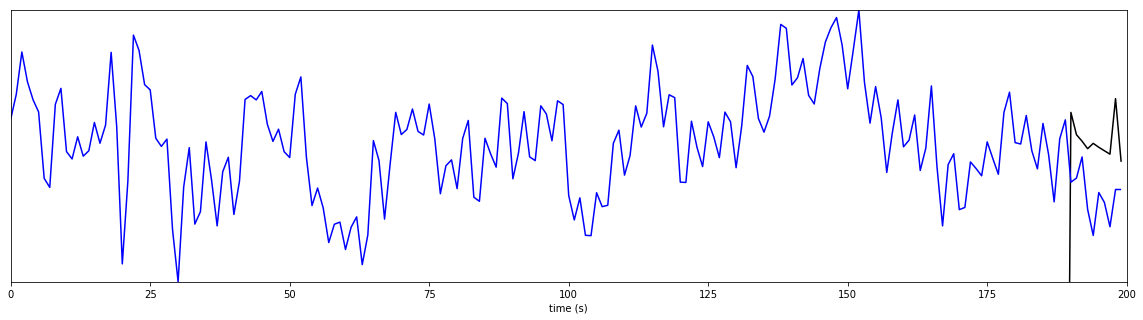

In [20]:
model.eval()
sample_recording = train_dataset[random.randint(0, len(train_dataset) -1)]
vizualize_pred(sample_recording[:, -200:], model)

#### sliding window

In [21]:
# create seperate sliding datasets with larger input length
num_preds = 200
train_dataset_sliding = EEGDataset(train_dataset_csv, length + num_preds, select_channels, max_num_examples=100, transform=normalize, filter_freq=True)
dev_dataset_sliding = EEGDataset(dev_dataset_csv, length + num_preds, select_channels, max_num_examples=100, transform=normalize, filter_freq=True)

Found 2765 recordings
By set limit only using 100 recordings
Removing recordings of insufficient length...
Removed 6 of 100 recordings. There are now 94 recordings.
Found 345 recordings
By set limit only using 100 recordings
Removing recordings of insufficient length...
Removed 5 of 100 recordings. There are now 95 recordings.


In [22]:
batch = iter(train_loader).next()
batch = torch.transpose(batch, 1, 2)
if check_model_is_cuda(model):
    batch = batch.cuda()
# preds = preds_with_sliding_window(x=batch, num_inputs=240, num_preds=10, model=model)
# preds = preds_with_sliding_window(x=batch, num_inputs=100, model=model)
# preds = preds_with_sliding_window(x=batch, num_inputs=length, model=model)

things to try:
[] train with more input (mins not seconds) , 12000, 24000...
[] see if params changing 
[] try plugging in EEG dataset to their code?
[] vizualize arima and lstml on same plot, see error depending on prediction length

Making 200 preds


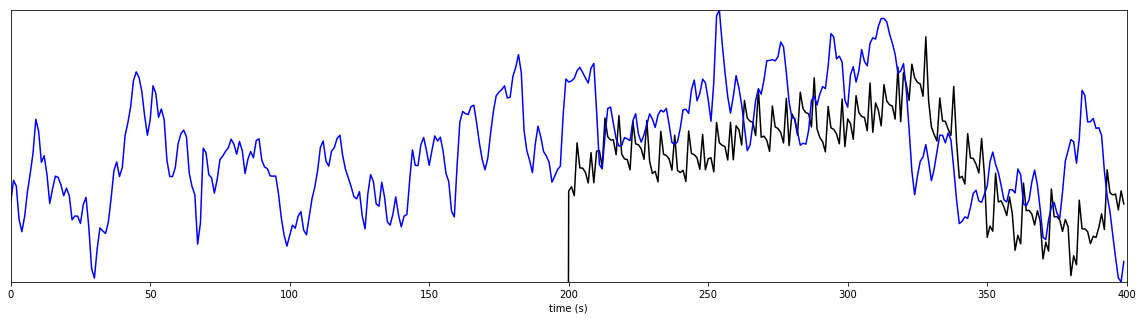

In [28]:
sample_recording = train_dataset_sliding[random.randint(0, len(train_dataset_sliding) -1)]
model.cuda()
vizualize_sliding_preds(sample_recording, model, input_length=length, num_points_show=400)

telemon start with sin waves
https://github.com/khundman/telemanom/tree/master/telemanom
then add white noise

change time(s) to 

Making 200 preds


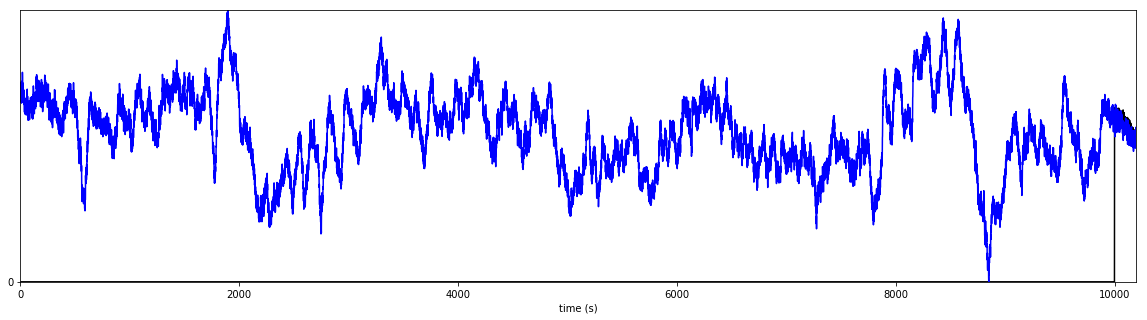

In [27]:
sample_recording = dev_dataset_sliding[random.randint(0, len(dev_dataset_sliding) -1)]
vizualize_sliding_preds(sample_recording, model, input_length=length)

try one point sliding window 

HIPPO https://arxiv.org/pdf/2008.07669.pdf

### Baselines

#### Average 

In [ ]:
average_model = Average(n_predictions)
sample_recording = train_dataset[random.randint(0, len(train_dataset) -1)]
vizualize_pred(sample_recording[:, -200:], average_model)

#### Auto-ARIMA 

In [31]:
import numpy as np
np.version.version

'1.19.5'

In [32]:
i = 0

In [45]:
i += 1
sample = train_dataset[i].squeeze().numpy()
train = sample[-100:-20]
test = sample[-20:]

In [34]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


model = pm.auto_arima(train, seasonal=True, m=12)

In [43]:
forecasts = model.predict(test.shape[0])  # predict N steps into the future

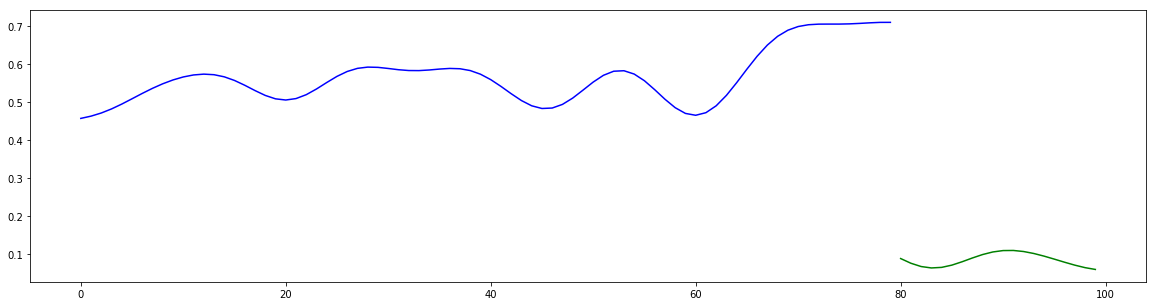

In [46]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(100)
plt.plot(x[:80], train, c='blue')
plt.plot(x[80:], forecasts, c='green')
plt.show()

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(5, 1, 3)   Log Likelihood                 687.478
Date:                Thu, 28 Jan 2021   AIC                          -1354.956
Time:                        13:09:16   BIC                          -1331.262
Sample:                             0   HQIC                         -1345.464
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.158e-06   3.87e-06     -1.590      0.112   -1.37e-05    1.43e-06
ar.L1          4.2896      0.002   1947.996      0.000       4.285       4.294
ar.L2         -7.8089      0.001  -1.04e+04      0.000      -7.810      -7.807
ar.L3          7.4865      0.002   4293.330      0.000       7.483       7.490
ar.L4         -3.7737      0.001  -5596.839      0.000      -3.775      -3.772
ar.L5          0.7985      0.002    379.999      0.000       0.794       0.803
ma.L1       1.652e-06   3.68e-05      0.045      0.964   -7.04e-05    7.37e-05
ma.L2       2.005e-06   3.72e-05      0.054      0.957    -7.1e-05     7.5e-05
ma.L3      -1.447e-06    3.9e-05     -0.037      0.970    -7.8e-05    7.51e-05
sigma2      1.119e-09   4.52e-10      2.476      0.013    2.33e-10       2e-09
===================================================================================
Ljung-Box (L1) (Q):                  58.29   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.00   Prob(JB):                         0.60
Heteroskedasticity (H):               0.96   Skew:                             0.14
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+20. Standard errors may be unstable.
"""

### Vizualize TFR Preds

In [70]:
X_train = []
y_train = []

In [71]:
for j in range(len(train_dataset)):
    if j == 500:
        break
    for i in range(1):
        start = i * 250 + 500
        end = start + 250
        pred_end = end + 10
        X_train.append(train_dataset[j][:, start:end].numpy())
        y_train.append(train_dataset[j][:, end:pred_end].numpy())

In [72]:
X_train = torch.from_numpy(np.asarray(X_train))
y_train = torch.from_numpy(np.asarray(y_train))

In [73]:
X_train = X_train.numpy()
y_train = y_train.numpy()

In [74]:
y_train = np.squeeze(y_train)
# X_train = np.squeeze(X_train)

In [64]:
X_train.shape

(500, 1, 250)

In [65]:
y_train.shape

(500, 1, 10)

In [ ]:
X_train = []
y_train = []

In [12]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import os

In [13]:
model = Sequential()

model.add(LSTM(
    80,
    input_shape=(None, X_train.shape[2]),
    return_sequences=True)
)

model.add(Dropout(.3))

model.add(LSTM(
    80,
    return_sequences=False)
)

model.add(Dropout(.3))

model.add(Dense(10))
model.add(Activation('linear'))

model.compile(loss='mse',
               optimizer='adam')

model.fit(X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_split=.2,
)

NameError: name 'X_train' is not defined

In [159]:
i = 4
x = train_dataset[i][:, :250].numpy().reshape(1, 1, 250)
y = model.predict(x)
a = train_dataset[i][:, :260].numpy().squeeze() 

In [160]:
z = np.concatenate([x.squeeze(), y.squeeze()])

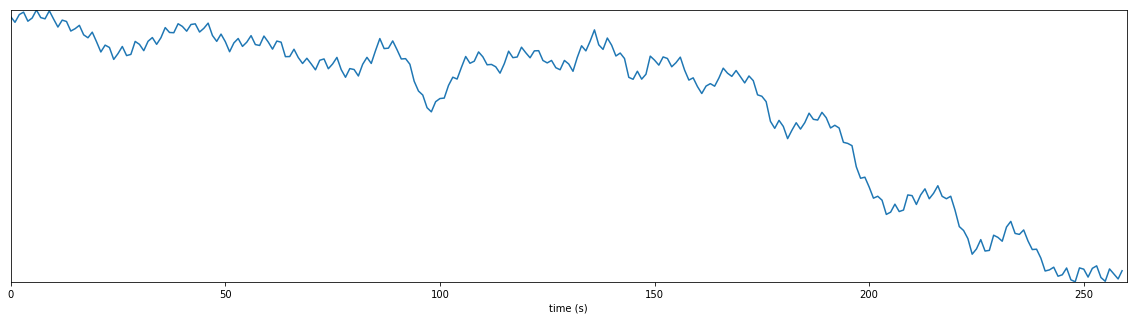

In [161]:
stackplot(z.reshape(1, 260))

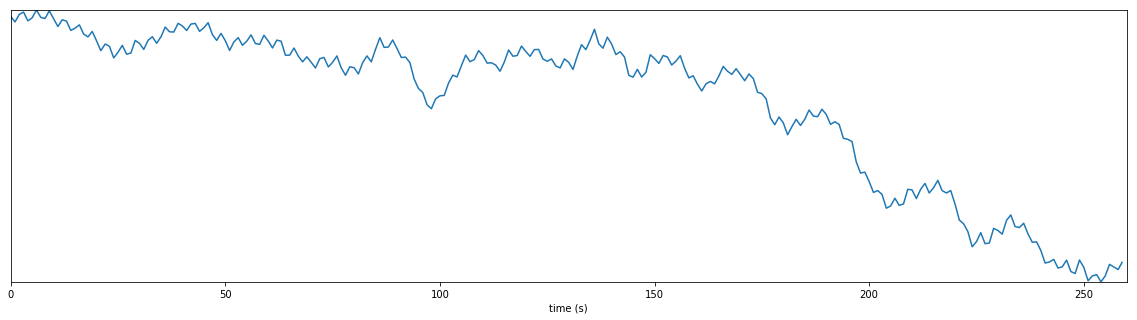

In [162]:
stackplot(a.reshape(1, 260))

In [8]:
import tensorflow as tf

/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/home2/dlongo/.conda/envs/mne-4/lib/pyt

In [9]:
tf.__version__

'1.14.0'

In [10]:
import keras

Using TensorFlow backend.


In [11]:
keras.__version__

'2.3.0'

In [20]:
import torch


In [22]:
torch.__version__

'1.0.1.post2'

In [ ]:
# try updating torch in new env